# KITSUNE: Training Zephyr 7B-beta with papers from ACM CHI 2023

This notebook will walk you through the loading, training, and testing of the preliminary KITSUNE model used in the paper "How to write a CHI paper (asking for a friend)" submitted at alt.chi (CHI 2024).

1. We load the model and necessary data
 * (data not included - but please read our README file in github (https://github.com/aeau/kitsune) to know the process on how to collect the necessary data and preprocess).
2. We prepare the model for training and fine-tuned for the particular task
3. We prepare a set of prompts that is used and sampled for the paper.


 NOTE: This notebook is an adaptation from the notebook and tutorial presented in this blog post: https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-mistral-7b-instruct-model-0f39647b20fe. The post included a notebook to fine-tune Mistral-7b using different libraries. We adapted it to be able to support the type of data we used and zephyr-7b-beta, which is already a fine-tuned model from Mistral-7b.

## Step 0 -  Define some helper functions :
1. Enable text wrapping so we don't have to scrool horizontally
2. Define a wrapper function which pass our query to the model for inference and return decoded model's completion(response).


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)


Let's define a wrapper function which will get completion from the model from a user question

In [ ]:
def get_completion(query: str, model, tokenizer) -> str:
  device = "cuda:0"

  prompt_template = """
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  ### Question:
  {query}

  ### Answer:
  """
  prompt = prompt_template.format(query=query)

  encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)

  model_inputs = encodeds.to(device)


  generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.batch_decode(generated_ids)
  return (decoded[0])

## Step 1 - Install necessary packages
First, install the dependencies below to get started. As these features are available on the main branches only, we need to install the libraries below from source.

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00


## Step 2 - Model loading
We'll load the model using QLoRA quantization to reduce the usage of memory


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

Now we specify the model ID and then we load it with our previously defined quantization configuration.

In [ ]:
model_id = 'HuggingFaceH4/zephyr-7b-beta'

# model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

We define a method to parse and convert the output of the model to the expected prompt template.

In [ ]:
def parse_chat_template(chat_template):
    lines = chat_template.strip().split('\n')
    parsed_data = []
    new_role = ""
    parsed_role = ""
    current_content = ""
    # print(len(lines))
    role_index = 0

    for i, line in enumerate(lines):
        #print(line)
        line = line.strip()
        if (line.startswith("<|system|>") or line.startswith("\n<|system|>")):
          if new_role != "":
            parsed_data.append({"role": parsed_role, "content": "\n".join(lines[role_index+1:i])})
          role_index = i
          new_role = "<|system|>"
          parsed_role = "system"
        elif (line.startswith("<|user|>") or line.startswith("\n<|user|>")):
          if new_role != "":
            parsed_data.append({"role": parsed_role, "content": "\n".join(lines[role_index+1:i])})
          role_index = i
          new_role = "<|user|>"
          parsed_role = "user"
        elif (line.startswith("<|assistant|>") or line.startswith("\n<|assistant|>")):
          # print("\n \n \n IS THIS HAPPENING?")
          if new_role != "":
            parsed_data.append({"role": parsed_role, "content": "\n".join(lines[role_index+1:i])})
          role_index = i
          new_role = "<|assistant|>"
          parsed_role = "assistant"

        if i == len(lines)-1:
          parsed_data.append({"role": parsed_role, "content": "\n".join(lines[role_index+1:])})

    return parsed_data

## Run a inference on the base model. We test how content is generated with the base model in comparison with the fine-tuned model.

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Write only the Introduction section for an ACM CHI Paper about a novel emotion regulation technology."},]

messages_to_add = [{"role": "user", "content": "Write only the Related Work section for an ACM CHI Paper about a novel emotion regulation technology."},
                   {"role": "user", "content": "Write only the Methodology section for an ACM CHI Paper about a novel emotion regulation technology."},
                   {"role": "user", "content": "Write only the Discussion section for an ACM CHI Paper about a novel emotion regulation technology."},
                  {"role": "user", "content": "Write only the Conclusion section for an ACM CHI Paper about a novel emotion regulation technology"},
                   {"role": "user", "content": "Write only the References section for an ACM CHI Paper about a novel emotion regulation technology."}]
message_counter = 0
memory_buffer = 5
step_counter = 0

while step_counter < len(messages_to_add) + 1:
  memory_buffer -= 1
  step_counter += 1

  gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

  gen_output = model.generate(input_ids=gen_input,
                              max_new_tokens=900,
                              min_new_tokens=800,
                              do_sample=True,
                              temperature=0.7,
                              top_k=50,
                              top_p=0.95,
                              repetition_penalty=1.1)
  out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
  print(out)

  print("\n \n")
  messages = parse_chat_template(out)
  if message_counter < len(messages_to_add):
    messages.append(messages_to_add[message_counter])
  message_counter += 1
  #messages.append({"role": "user", "content": "Can you add the references to your generated text."})



In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Write only the Introduction section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},]

messages_to_add = [{"role": "user", "content": "Write only the Related Work section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the Methodology section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the Discussion section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                  {"role": "user", "content": "Write only the Conclusion section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the References section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."}]
message_counter = 0
memory_buffer = 5
step_counter = 0

while step_counter < len(messages_to_add) + 1:
  memory_buffer -= 1
  step_counter += 1

  gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

  gen_output = model.generate(input_ids=gen_input,
                              max_new_tokens=900,
                              min_new_tokens=800,
                              do_sample=True,
                              temperature=0.7,
                              top_k=50,
                              top_p=0.95,
                              repetition_penalty=1.1)
  out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
  print(out)

  print("\n \n")
  messages = parse_chat_template(out)
  if message_counter < len(messages_to_add):
    messages.append(messages_to_add[message_counter])
  message_counter += 1
  #messages.append({"role": "user", "content": "Can you add the references to your generated text."})



## I. Dataset


**Prepare data**

Load the data (not included)

In [ ]:
from datasets import load_dataset
import pandas as pd

#df = pd.read_excel("chi-2023-data-chunk-and-reference.xlsx")  # Dataset 1
df = pd.read_excel("chi-2023-data-no-references-2048-parts.xlsx")  # Dataset 2

In [ ]:
df.head(3)

,Unnamed: 0,text
0,0,User: User: Write the INTRODUCTION of an ACM C...
1,1,User: User: Write the ETHICS IN SOMA DESIGN of...
2,2,User: User: Write the CASE STUDY: SOMAESTHETIC...


In [ ]:
# Get tokenizer
import transformers
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def text_to_dialogue(text):
    return [sentence.replace('User:', '').replace('Chip:', '').strip() for sentence in text.split('Assistant:')]

def dialogue_to_chat(dialogue):
    out = [{'role': 'system', 'content': 'You are a researcher writing a paper for the ACM CHI conference.'}]
    for idx, message in enumerate(dialogue):
        role = 'user' if idx%2==0 else 'assistant'
        out.append({'role': role, 'content': message})
    return out

def chat_to_input(chat):
    return tokenizer.apply_chat_template(chat, tokenize=False)

def process_example(example):
    out = text_to_dialogue(example)
    out = dialogue_to_chat(out)
    out = chat_to_input(out)
    return out

In [ ]:
example = df['text'].iloc[6270]

print(example)
print()
print(process_example(example))

In [ ]:
data = list(map(process_example, df['text']))

In [ ]:
from random import shuffle
shuffle(data)

In [ ]:
tokenized_data = list(map(tokenizer, data))

In [ ]:
max_len = 0
for x in tokenized_data:
    max_len = max(max_len, len(x['input_ids']))

print(max_len)
len(tokenized_data)


7055


8502

In [ ]:
max_length = 3072
filtered_list = [x for x in tokenized_data if len(x['input_ids']) <= max_length]

max_len = 0
for x in filtered_list:
    max_len = max(max_len, len(x['input_ids']))

print(max_len)
len(filtered_list)

3071


7601

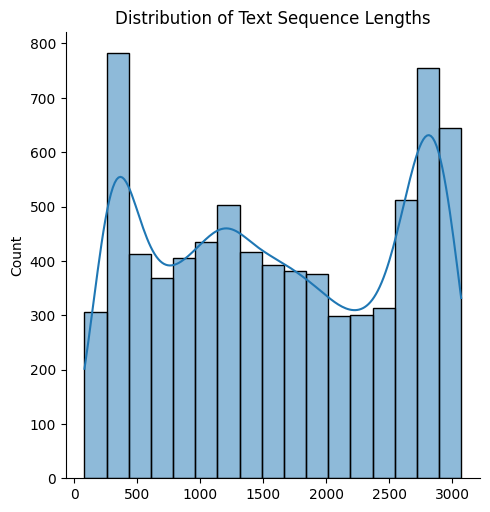

In [ ]:
# Plot sequence Lengths
import seaborn as sns

input_lengths = [len(x['input_ids']) for x in filtered_list]
sns.displot(input_lengths, kde=True).set(title='Distribution of Text Sequence Lengths')

In [ ]:
split_idx = int(.99 * len(filtered_list))
train_data, val_data = filtered_list[:split_idx], filtered_list[split_idx:]

In [ ]:
len(train_data), len(val_data)

## Step 3 - Apply Lora  
Here comes the magic with peft! Let's load a PeftModel and specify that we are going to use low-rank adapters (LoRA) using get_peft_model utility function and  the prepare_model_for_kbit_training method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
  

Use the following function to find out the linear layers for fine tuning.
QLoRA paper : "We find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block layers is required to match full finetuning performance."

In [ ]:
import bitsandbytes as bnb
def find_all_linear_names(model):
  cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
  lora_module_names = set()
  for name, module in model.named_modules():
    if isinstance(module, cls):
      names = name.split('.')
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: # needed for 16-bit
      lora_module_names.remove('lm_head')
  return list(lora_module_names)

In [ ]:
modules = find_all_linear_names(model)
print(modules)

['gate_proj', 'v_proj', 'down_proj', 'up_proj', 'o_proj', 'q_proj', 'k_proj']


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [ ]:
trainable, total = model.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")


Trainable: 20971520 | total: 7262703616 | Percentage: 0.2888%


## Step 4 - Run the training!

Setting the training arguments:
* for the reason of demo, we just ran it for few steps (30)

In [ ]:
import transformers

tokenizer.pad_token = tokenizer.eos_token

# Setup Callbacks
early_stop = transformers.EarlyStoppingCallback(10, 1.15)      #hard to finetune further on general tasks like assitance

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=0.03,
        max_steps=30,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs_mistral_to_zephyr_chi23",
        optim="paged_adamw_8bit",
        save_strategy="epoch"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)


Start the training

In [ ]:
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()


## Step 5 Evaluating the model qualitatively: run an inference!

Here you can see not only output that is used in the paper, but also other output from the model that was tried as part of the iterative development process.


Load directly adapters from the Hub using the command below

In [ ]:
# Save the fine-tuned model
new_model = "zephyr-7b-prechi-23" #set the name of the new model
trainer.model.save_pretrained(new_model)

In [ ]:
trainer.save_model("zephyr-7b-finetuned-chi23-noreferences")


### almost full sections (some chunks) 2048 tokens more or less without references

In [ ]:
model.config.use_cache = True

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Write only the Introduction section for an ACM CHI Paper about a novel emotion regulation technology."},]

messages_to_add = [{"role": "user", "content": "Write only the Related Work section for an ACM CHI Paper about a novel emotion regulation technology."},
                   {"role": "user", "content": "Write only the Methodology section for an ACM CHI Paper about a novel emotion regulation technology."},
                   {"role": "user", "content": "Write only the Discussion section for an ACM CHI Paper about a novel emotion regulation technology."},
                   {"role": "user", "content": "Write only the Conclusion section for an ACM CHI Paper about a novel emotion regulation technology"},
                   {"role": "user", "content": "Write only the References section for an ACM CHI Paper about a novel emotion regulation technology."}]
message_counter = 0
memory_buffer = 5
step_counter = 0

while step_counter < len(messages_to_add) + 1:
  memory_buffer -= 1
  step_counter += 1

  gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

  gen_output = model.generate(input_ids=gen_input,
                              max_new_tokens=900,
                              min_new_tokens=800,
                              do_sample=True,
                              temperature=0.7,
                              top_k=50,
                              top_p=0.95,
                              repetition_penalty=1.1)
  out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
  print(out)

  print("\n \n")
  messages = parse_chat_template(out)
  if message_counter < len(messages_to_add):
    messages.append(messages_to_add[message_counter])
  message_counter += 1
  #messages.append({"role": "user", "content": "Can you add the references to your generated text."})



<|system|>
You are a researcher writing a paper for the ACM CHI conference. 
<|user|>
Write only the Introduction section for an ACM CHI Paper about a novel emotion regulation technology. 
<|assistant|>
1 INTRODUCTION 
       
      
      Emotional intelligence (EI) is a crucial skill to navigate complex social environments and has been found to be related to several positive outcomes such as academic success, job performance, and overall life satisfaction [10, 34]. However, studies have also revealed that some individuals may lack EI skills or experience emotional difficulties in their daily lives [54]. In fact, a recent study by Fang et al. [26] found that more than half of their participants (N = 125) self-reported experiencing negative emotions, including anxiety, depression, anger, and stress, on a regular basis. Moreover, these findings suggest that individuals with low EI skills tend to have more negative emotions in their daily lives than those with high EI skills. To address 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-5e869c716ccc>", line 21, in <cell line: 15>
    gen_output = model.generate(input_ids=gen_input,
  File "/usr/local/lib/python3.10/dist-packages/peft/peft_model.py", line 1128, in generate
    outputs = self.base_model.generate(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py", line 1756, in generate
    return self.sample(
  File "/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py", line 2853, in sample
    outputs = self(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **k

TypeError: ignored

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Write only the Introduction section for an ACM CHI Paper on which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},]

messages_to_add = [{"role": "user", "content": "Write only the Related Work section for an ACM CHI Paper on which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the Discussion section for an ACM CHI Paper on which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the References section for an ACM CHI Paper on which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."}]
message_counter = 0
memory_buffer = 3

while memory_buffer > 0:
  memory_buffer -= 1

  gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

  gen_output = model.generate(input_ids=gen_input,
                              max_new_tokens=512,
                              do_sample=True,
                              temperature=0.7,
                              top_k=50,
                              top_p=0.95,
                              repetition_penalty=1.1)
  out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
  print(out)

  print("\n \n")
  messages = parse_chat_template(out)
  messages.append(messages_to_add[message_counter])
  message_counter += 1
  #messages.append({"role": "user", "content": "Can you add the references to your generated text."})



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<|system|>
You are a researcher writing a paper for the ACM CHI conference. 
<|user|>
Write only the Introduction section for an ACM CHI Paper on which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing. 
<|assistant|>
1 INTRODUCTION 
       
      
     The world is growing increasingly more connected as we have seen in recent years. A report by Cisco[23] predicted that there will be 14 devices per person and 50 billion devices connected to the internet by 2030. This means that there are already an overwhelming number of devices and services people use every day. People need ways to manage their digital lives, including the information they collect about themselves. In the last decade, there has been a proliferation of smart home systems, fitness trackers, personal assistants, and other devices designed to make life easier and healthier. While these products aim to simplify people's lives, they also demand more of thei

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Write a short paper that includes Introduction, Related Work, Analysis, Discussion, and Conclusions for ACM CHI about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},]
gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

gen_output = model.generate(input_ids=gen_input,
                            max_new_tokens=2048,
                            do_sample=True,
                            temperature=0.7,
                            top_k=50,
                            top_p=0.95,
                            repetition_penalty=1.1)
out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
print(out)

<|system|>
You are a researcher writing a paper for the ACM CHI conference. 
<|user|>
Write a short paper that includes Introduction, Related Work, Analysis, Discussion, and Conclusions for ACM CHI about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing. 
<|assistant|>
2 ANALYSIS                          This section details our analysis using a corpus consisting of the full text of all ACM CHI papers from 2015 to 2021 (N = 764). We first introduce the methods we used to identify the frequency of each writing convention, then present our findings regarding the use of writing conventions in ACM CHI papers.                                    2.1 Data Preparation                        To study the evolution of writing conventions over time, we created a corpus consisting of the full text of all ACM CHI papers published between 2015 and 2021. The corpus consisted of 764 papers, with an average length of 16 pages. Th

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Write only the Introduction section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},]

messages_to_add = [{"role": "user", "content": "Write only the Related Work section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the Methodology section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the Discussion section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                  {"role": "user", "content": "Write only the Conclusion section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."},
                   {"role": "user", "content": "Write only the References section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing."}]
message_counter = 0
memory_buffer = 5
step_counter = 0

while step_counter < len(messages_to_add) + 1:
  memory_buffer -= 1
  step_counter += 1

  gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

  gen_output = model.generate(input_ids=gen_input,
                              max_new_tokens=1024,
                              min_new_tokens=800,
                              do_sample=True,
                              temperature=0.7,
                              top_k=50,
                              top_p=0.95,
                              repetition_penalty=1.1)
  out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
  print(out)

  print("\n \n")
  messages = parse_chat_template(out)
  if message_counter < len(messages_to_add):
    messages.append(messages_to_add[message_counter])
  message_counter += 1
  #messages.append({"role": "user", "content": "Can you add the references to your generated text."})



<|system|>
You are a researcher writing a paper for the ACM CHI conference. 
<|user|>
Write only the Introduction section for an ACM CHI Paper about which writing conventions are the most common within ACM CHI conference papers with the help of natural language processing. 
<|assistant|>
1 INTRODUCTION 
       
      
     The ACM CHI conference is one of the most significant events in human-computer interaction (HCI). It annually attracts more than 2,000 researchers and practitioners from around the world to share their work in HCI through numerous presentations, workshops, tutorials, panels, and other activities. The conference is held in different locations every year[6]. In this paper, we explore the structure and content of the papers presented at ACM CHI conferences from 1997 to 2019. Specifically, we aim to investigate the following questions: 
        
         
           
           
             1. How do the structures of ACM CHI papers change over time? 
            
     

OutOfMemoryError: ignored

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a researcher writing a paper for the ACM CHI conference."},
    {"role": "user", "content": "Hi, can you write a CHI Paper with references."},]
gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

gen_output = model.generate(input_ids=gen_input,
                            max_new_tokens=4096,
                            do_sample=True,
                            temperature=0.7,
                            top_k=50,
                            top_p=0.95,
                            repetition_penalty=1.1)
out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
print(out)